In [1]:
from main import *
from sklearn import clone

DROP_COLS = ["car_ownership", "house_ownership", "married"]

In [2]:
df_train, df_test = data_preprocess([], SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)
df_train.head(10)

Training data shape: (252000, 15) ; Test data shape: (28000, 14)


,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag,income_per_state,income_per_profession,has_house
0,1303835,23,3,1,2,0,33,251,13,3,13,0,4735088.0,5351331.0,0
1,7574516,40,10,1,2,0,43,227,14,9,13,0,5192166.5,4994848.0,0
2,3991815,66,4,0,2,0,47,8,12,4,10,0,5421502.0,4813985.0,0
3,6256451,41,2,1,2,1,43,54,17,2,12,1,4834921.5,4994848.0,0
4,5768871,47,11,1,2,0,11,296,22,3,14,1,5074244.0,5056892.0,0
5,6915937,64,0,1,2,0,11,130,14,0,12,0,5192166.5,5056892.0,0
6,3954973,58,14,0,2,0,31,299,22,8,12,0,5074244.0,5384499.0,0
7,1706172,33,2,1,2,0,20,134,6,2,14,0,5265885.0,4940114.0,0
8,7566849,24,17,1,2,1,25,165,20,11,11,0,5315413.0,4608251.0,0
9,8964846,23,12,1,2,0,2,149,23,5,13,0,4942553.0,4950300.0,0


In [ ]:
col = "current_job_years"
sns.histplot(x=col, data=df_train, label="train", color='g', stat="density", binwidth=1, alpha=0.5)
sns.histplot(x=col, data=df_test, label="test", color='r', stat="density", binwidth=1, alpha=0.5)
plt.show()

<AxesSubplot:xlabel='city', ylabel='state'>

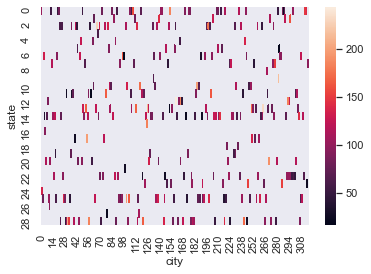

In [15]:
sns.heatmap(df_train.pivot_table(values="risk_flag", index="state", columns="city", aggfunc="sum"))

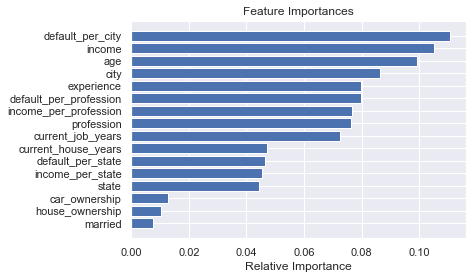

In [3]:
model = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_features=1)
model = train_model(model, df_train)
features = df_train.drop("risk_flag", axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Training data shape: (252000, 11) ; Test data shape: (28000, 10)
Training data shape: (252000, 17) ; Test data shape: (28000, 16)
Training data shape: (252000, 14) ; Test data shape: (28000, 13)
Training data shape: (252000, 14) ; Test data shape: (28000, 13)


<AxesSubplot:>

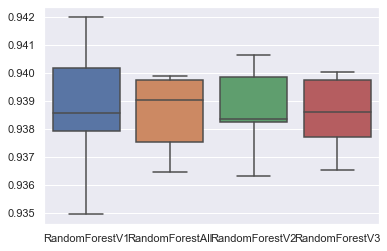

In [4]:
clf = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_features=1)
models = {
    "RandomForestV1": [clone(clf), ["car_ownership", "house_ownership", "married", "profession", "city", "state"]],
    "RandomForestAll": [clone(clf), []],
    "RandomForestV2": [clone(clf), ["profession", "city", "state"]],
    "RandomForestV3": [clone(clf), ["car_ownership", "house_ownership", "married"]]
}

res = pd.DataFrame.from_dict(
        {model_name: eval_model(model, data_preprocess(drop_cols, SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)[0]) for model_name, (model, drop_cols) in models.items()}    
    )
sns.boxplot(data=res)

In [ ]:
model = RandomForestClassifier(n_estimators=1000, max_features=1, class_weight="balanced", n_jobs=-1)
df_train, df_test = data_preprocess(drop_cols=["car_ownership", "house_ownership", "married"], transform_fns=transforms)
sub = make_submission(model, df_train, df_test)
sub.to_csv("./tuning_rf/sub4.csv")

## Note: can safely remove `["car_ownership", "house_ownership", "married"]`

Training data shape: (252000, 14) ; Test data shape: (28000, 13)


<AxesSubplot:>

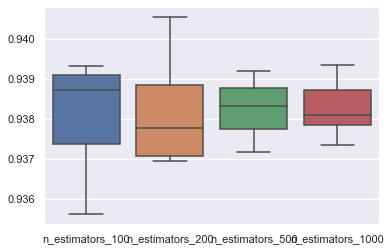

In [2]:
drop_cols = ["car_ownership", "house_ownership", "married"]
df_train = data_preprocess(drop_cols, SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)[0]

param = "n_estimators"
par_vals = [100, 200, 500, 1000]

res = pd.DataFrame.from_dict(
        {f"{param}_{val}": eval_model(RandomForestClassifier(n_jobs=-1, **{param: val}), df_train)
                                      for val in par_vals}
    )
sns.boxplot(data=res)

## Note: a smaller `max_features` value seems better
---

In [ ]:
drop_cols = ["car_ownership", "house_ownership", "married"]
df_train = data_preprocess(drop_cols, [income_by_state])[0]

param = "colsample_bytree"
par_vals = [0.6, 0.7, 0.8, 0.9]

res = pd.DataFrame.from_dict(
        {f"{param}_{val}": eval_model(XGBClassifier(
            n_estimators=200, 
            learning_rate=0.1,
            reg_alpha=1e-3,
            tree_method="gpu_hist",
            scale_pos_weight=12,
            **{param: val}), df_train)
                                      for val in par_vals}
    )
sns.boxplot(data=res)

In [ ]:
from sklearn.ensemble import StackingClassifier
models = [
    ("rfV1", RandomForestClassifier(n_estimators=200, n_jobs=2)),
    ("rfV2", RandomForestClassifier(n_estimators=200, class_weight="balanced", max_features=1, n_jobs=2)),
    ("xgb", XGBClassifier(n_estimators=5000, 
            learning_rate=0.01,
            tree_method="gpu_hist",
            scale_pos_weight=7.13,
            min_child_weight=2,
            colsample_bytree=0.6)),
]

final_estimator = RandomForestClassifier(n_estimators=1000, class_weight="balanced", n_jobs=2)
model = StackingClassifier(estimators=models, final_estimator=final_estimator, cv=CV, verbose=1000)

df_train = data_preprocess(DROP_COLS, [income_by_state])[0]
eval_model(model, df_train)

In [ ]:
df_train = data_preprocess([], SINGLE_TRANSFORMS, DOUBLE_TRANSFORMS)[0]
sns.heatmap(x="state", y="house_ownership", hue="risk_flag")

In [ ]:
from sklearn.model_selection import train_test_split
def get_model_outputs(models):
    df_train = data_preprocess(
            drop_cols=["car_ownership", "house_ownership", "married"],
            transform_fns=[income_by_state]
        )[0]

    scores = {}
    for name, model in models.items():
        print(f"Cross-validating: {name}")
        scores[name] = eval_model(model, df_train)
    scores = pd.DataFrame.from_dict(scores)
    
    X, y = df_train.drop("risk_flag", axis=1).values, df_train["risk_flag"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    for name in models.keys():
        models[name].fit(X_train, y_train)
    
    preds = {name: model.predict(X_test) for name, model in models.items()}
    return preds, scores

In [1]:
from ensembling import *

In [7]:
df_train = pd.read_csv("./ensemble_files/final_train.csv")
df_train.head()

,id,rfv1_preds,rfv2_preds,dtreev1_preds,dtreev2_preds,dtreev3_preds,etreev1_preds,etreev2_preds,etreev3_preds,targets
0,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0
3,4,1,1,1,0,1,1,1,0,1
4,5,1,0,0,0,0,0,0,0,1


In [8]:
import seaborn as sns
sns.heatmap(df_)

NameError: name 'sns' is not defined

In [9]:
from bayes_opt import BayesianOptimization    
def lightgbm_tuning(df_train):
    df_train = lgb.Dataset(
            data=df_train.drop(["id", "targets"], axis=1).values, 
            label=df_train["targets"].values,
            free_raw_data=False
        )

    def lgb_eval(**params):
        config = {"device": "gpu", "metric": "auc", "boosting_type": "goss", "verbose": -1}
        config.update(params) 

        config["num_leaves"] = int(round(config["num_leaves"]))
        config["max_bin"] = int(round(config["max_bin"]))
        config["max_depth"] = int(round(config["max_depth"]))

        cv_result = lgb.cv(config, df_train, nfold=5, stratified=True, shuffle=True, metrics=["auc"], verbose_eval=False)
        return max(cv_result["auc-mean"])
    
    pbounds = {
        "num_leaves": (80, 250),
        "max_bin": (25, 250),
        "scale_pos_weight": (5, 15),
        "colsample_bytree": (0.1, 0.9),
        "subsample": (0.1, 0.9),
        "max_depth": (2, 25)
    }

    lgBO = BayesianOptimization(lgb_eval, pbounds)
    lgBO.maximize(init_points=15, n_iter=25)
    
    return lgBO

def xgboost_tuning(df_train):
    df_train = xgb.DMatrix(
            df_train.drop(["Id", "risk_flag"], axis=1).values, 
            label=df_train["risk_flag"].values,
        )
    
    def xgb_eval(**params):
        config = {"tree_method": "gpu_hist", "eval_metric": ["auc"], "learning_rate": 0.1}
        config.update(params)
        
        config["max_depth"] = int(round(config["max_depth"]))
        config["min_child_weight"] = int(round(config["min_child_weight"]))
        
        cv_result = xgb.cv(config, df_train, nfold=5, stratified=True, shuffle=True, metrics=["auc"], verbose_eval=False)
        return max(cv_result["test-auc-mean"])
    
    pbounds = {
        "max_depth": (5, 25),
        "min_child_weight": (2, 16),
        "colsample_bytree": (0.1, 0.9),
        "subsample": (0.1, 0.9),
        "gamma": (0.1, 1.0),
        "scale_pos_weight": (5, 15)
    }
    
    xgBO = BayesianOptimization(xgb_eval, pbounds)
    xgBO.maximize(init_points=20, n_iter=40)
    
    return xgBO

In [10]:
# df_train, df_test = data_preprocess(
#     drop_cols=[],
#     transforms=SINGLE_TRANSFORMS
# )

df_train = pd.read_csv("./ensemble_files/final_train.csv")
lgBO = lightgbm_tuning(df_train)

# xgBO = xgboost_tuning(df_train)

|   iter    |  target   | colsam... |  max_bin  | max_depth | num_le... | scale_... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.9424   |  0.4094   |  127.5    |  13.6     |  97.32    |  14.17    |  0.7335   |
|  2        |  0.9424   |  0.4387   |  215.5    |  9.407    |  115.7    |  12.64    |  0.1697   |
|  3        |  0.941    |  0.2748   |  119.0    |  17.84    |  143.4    |  12.67    |  0.258    |
|  4        |  0.9411   |  0.2834   |  96.19    |  6.896    |  128.3    |  13.86    |  0.4537   |
|  5        |  0.9428   |  0.7911   |  164.3    |  17.57    |  142.8    |  9.339    |  0.4236   |
|  6        |  0.9411   |  0.1909   |  86.11    |  12.91    |  122.4    |  12.69    |  0.2878   |
|  7        |  0.9417   |  0.3144   |  54.97    |  24.49    |  145.6    |  8.762    |  0.6551   |
|  8        |  0.9428   |  0.6377   |  173.2    |  7.812    |  190.8    |  10.55    |  0.8193   |
|  9        |  0.941

KeyboardInterrupt: 

In [19]:
lgBO.max

{'target': 0.9342476968886055,
 'params': {'colsample_bytree': 0.711263693734104,
  'max_bin': 191.1520924638712,
  'max_depth': 24.719186409019578,
  'num_leaves': 298.8966232805185,
  'scale_pos_weight': 12.23110875213706,
  'subsample': 0.2390470406490695}}